In [1]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_tavily import TavilySearch

In [2]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [3]:
llm = init_chat_model("groq:llama-3.3-70b-versatile")

tavily_tool = TavilySearch(max_results=3)

In [4]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="A brief overview of the main topics and concepts to be covered in this section.")

class Sections(BaseModel):
    sections: List[Section] = Field(description="The sections of the report.")


class Critique(BaseModel):
    revision_required: bool = Field(description="Whether the section requires revision.")
    feedback: str = Field(description="Constructive feedback for the writer on how to improve the section.")

class ReportState(TypedDict):
    topic: str
    sections: List[Section]
    current_section_index: int
    current_research_data: str
    draft_content: str
    feedback: Optional[str]
    revision_count: int
    completed_sections: Annotated[list, operator.add]
    final_report: str


In [5]:
def orchestrator(state: ReportState):
    """Orchestrator: Creates a plan (sections) for the report."""
    print("--- RUNNING ORCHESTRATOR ---")
    planner = llm.with_structured_output(Sections)
    report_sections = planner.invoke([
        SystemMessage(content="Create a detailed and comprehensive plan for a report."),
        HumanMessage(content=f"The report topic is: {state['topic']}"),
    ])
    return {"sections": report_sections.sections}



In [6]:
def researcher(state: ReportState):
    """Researcher: Conducts a web search for the current section."""
    print("--- RUNNING RESEARCHER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    print(f"-> Researching section: {current_section.name}")
    query = f"in-depth information on: {state['topic']} - {current_section.name}: {current_section.description}"
    search_result = tavily_tool.invoke(query)
    return {"current_research_data": search_result, "revision_count": 0}

In [7]:
def writer(state: ReportState):
    """Writer: Writes the current section, incorporating feedback if available."""
    print("--- RUNNING WRITER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    research_data = state['current_research_data']
    feedback = state.get('feedback')

    count = state.get("revision_count", 0)

    prompt_addition = ""
    if feedback:
        print(f"-> Revising section (Attempt {count + 1}) based on feedback: {feedback}")
        prompt_addition = f"""
        IMPORTANT: You MUST revise the section based on the following feedback. 
        Prioritize these instructions over all other rules.
        REVISION FEEDBACK: {feedback}
        """
    else:
        print(f"-> Writing new draft for section: {current_section.name}")

    writer_prompt = f"""
    Write the following section in detail, using the provided research findings.
    Write only the section content, without a title and without any preamble. Use Markdown formatting.
    {prompt_addition}
    SECTION NAME: {current_section.name}
    SECTION DESCRIPTION: {current_section.description}
    RESEARCH FINDINGS TO USE:
    {research_data}
    """
    section_content = llm.invoke([
        SystemMessage(content="You are an expert report writer."),
        HumanMessage(content=writer_prompt),
    ]).content
    return {"draft_content": section_content, "revision_count": count + 1}

In [8]:
def critic(state: ReportState):
    """Critic: Reviews the draft and decides if revision is needed."""
    print("--- RUNNING CRITIC ---")
    draft = state['draft_content']
    critic_llm = llm.with_structured_output(Critique)
    
    critique_prompt = f"""
    You are an expert editor. Please review the following draft section.
    Evaluate it for clarity, accuracy, and depth.
    If the section is generally good but could be slightly better, approve it. 
    Only request a revision if there are significant errors or omissions.
    Your feedback must be concrete and actionable.

    DRAFT:
    {draft}
    """
    review: Critique = critic_llm.invoke([
        SystemMessage(content="You are an expert editor and critic."),
        HumanMessage(content=critique_prompt),
    ])

    print(f"-> Critic's decision: Revision required? {review.revision_required}")
    if review.revision_required:
        return {"feedback": review.feedback}
    else:
        return {"feedback": None}


In [9]:
def section_collector(state: ReportState):
    """Collector: Adds the approved draft to the completed sections list."""
    print("--- RUNNING COLLECTOR ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    draft_content = state['draft_content']
    
    full_section = f"## {current_section.name}\n\n{draft_content}"
    
    next_index = current_index + 1
    return {"completed_sections": [full_section], "current_section_index": next_index}


In [10]:
def synthesizer(state: ReportState):
    """Synthesizer: Combines all completed sections into the final report."""
    print("--- RUNNING SYNTHESIZER ---")
    final_report = "\n\n---\n\n".join(state["completed_sections"])
    return {"final_report": final_report}


In [11]:
MAX_REVISIONS = 3

def should_loop_for_revision(state: ReportState):
    """Decides whether to loop back to the writer or collect the section."""
    print("--- CHECKING REVISION STATUS ---")
    feedback = state.get("feedback")
    count = state.get("revision_count", 0)

    if feedback and count < MAX_REVISIONS:
        print(f"-> Revision required (Attempt {count}). Looping back to writer.")
        return "writer"  
    else:
        if count >= MAX_REVISIONS:
            print(f"-> Max revisions of {MAX_REVISIONS} reached. Accepting current draft.")
        else:
            print("-> Draft approved by critic. Moving on.")
        return "section_collector"
    


def should_continue_or_synthesize(state: ReportState):
    if state['current_section_index'] >= len(state['sections']):
        return "synthesizer" 
    else:
        return "researcher" 

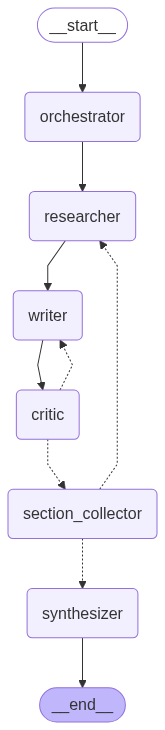

In [12]:
workflow = StateGraph(ReportState)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("researcher", researcher)
workflow.add_node("writer", writer)
workflow.add_node("critic", critic)
workflow.add_node("section_collector", section_collector)
workflow.add_node("synthesizer", synthesizer)


workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "critic")

workflow.add_conditional_edges(
    "critic",
    should_loop_for_revision,
    {"writer": "writer", "section_collector": "section_collector"}
)

workflow.add_conditional_edges(
    "section_collector",
    should_continue_or_synthesize,
    {"researcher": "researcher", "synthesizer": "synthesizer"}
)


workflow.add_edge("synthesizer", END)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
topic = "The career of Stephen Curry and his impact on the NBA"
initial_state = {
    "topic": topic,
    "current_section_index": 0,
    "completed_sections": []
}
final_state = app.invoke(initial_state, config={"recursion_limit": 100})

Markdown(final_state["final_report"])

--- RUNNING ORCHESTRATOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Introduction
--- RUNNING WRITER ---
-> Writing new draft for section: Introduction
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Early Career
--- RUNNING WRITER ---
-> Writing new draft for section: Early Career
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Rise to Prominence
--- RUNNING WRITER ---
-> Writing new draft for section: Rise to Prominence
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section:

## Introduction

### Background and Early Life
Stephen Curry, born on March 14, 1988, in Akron, Ohio, is a renowned American professional basketball player who has made a significant impact on the National Basketball Association (NBA). Curry's early life and background played a crucial role in shaping his future as a basketball star. He was born to Sonya and Dell Curry, and his father, a former NBA player, introduced him to the game at a young age. Curry's natural talent, combined with his dedication and hard work, eventually led him to become one of the most successful players in NBA history.

### Career Overview
Curry's professional basketball career began when he was selected by the Golden State Warriors with the seventh overall pick in the 2009 NBA draft. Since then, he has led the Warriors to four NBA championships (2015, 2017, 2018, and 2022) and has been named the league's Most Valuable Player (MVP) twice. Curry's impressive skills on the court, including his exceptional three-point shooting ability, have earned him numerous accolades and recognition as one of the greatest shooters in NBA history. In the 2015-2016 season, Curry led the Warriors to a league-record 73 wins, and he has consistently been among the top players in the league in terms of scoring and assists.

### Purpose of the Report
This report aims to provide an in-depth analysis of Stephen Curry's career, his impact on the NBA, and his achievements as a professional basketball player. The report will explore Curry's early life, his rise to fame, and his contributions to the Golden State Warriors' success. Additionally, it will examine Curry's statistics, awards, and accolades, as well as his influence on the game of basketball as a whole. By examining Curry's career and accomplishments, this report seeks to provide a comprehensive understanding of his significance in the world of basketball and his lasting impact on the sport.

---

## Early Career

### College Years
Stephen Curry's impressive basketball career began to take shape during his college years. As a college junior in 2009, Curry led the nation with an average of 28.6 points per game, showcasing his exceptional scoring ability. This outstanding performance would eventually catch the attention of NBA scouts and pave the way for his professional career.

### Draft Day
The Golden State Warriors selected Curry with the seventh pick of the NBA draft, marking the beginning of a successful partnership between the team and the young player. This draft pick would prove to be a pivotal moment in Curry's career, as he would go on to achieve great success and break numerous records with the Warriors.

### Early Seasons in the NBA
Curry's early seasons in the NBA were marked by significant growth and improvement. In the 2013-2014 season, he appeared in 78 games, averaging career highs of 24.0 points and 8.5 assists, while also contributing 4.3 rebounds and 1.63 steals per game. This impressive performance made him the first player in Warriors franchise history to average 24 points and eight assists in a single season, and the ninth player in NBA history to achieve this feat.

As Curry continued to develop his skills, he played a crucial role in the Warriors' success, helping the team win a league-record 73 games in the 2015-2016 season. He also led the team to multiple NBA championships, including back-to-back titles in 2015 and 2017. In the 2017 NBA Finals, Curry recorded his first career postseason triple-double with 32 points, 11 assists, and 10 rebounds, demonstrating his ability to perform under pressure and dominate games.

Throughout his early career, Curry consistently demonstrated his exceptional shooting ability, earning him numerous accolades, including multiple MVP awards. His impact on the NBA was significant, and he quickly became known as one of the most talented and influential players in the league.

---

## Rise to Prominence

### Breakthrough Seasons
Stephen Curry's rise to prominence in the NBA began with his breakthrough seasons, where he established himself as a dominant force in the league. After being selected with the seventh pick of the NBA draft by the Golden State Warriors in 2009, Curry quickly made a name for himself, leading the nation with an average of 28.6 points per game as a college junior. His impressive college performance translated to the professional level, where he continued to hone his skills and develop into a league superstar.

### First Championship and Emergence as a Superstar
Curry's first championship win came in 2015, when the Golden State Warriors won the NBA championship. This marked a significant milestone in Curry's career, as he emerged as a key player in the Warriors' success. The following season, Curry led the team to a league-record 73 wins, cementing his status as a league superstar. His impressive performance earned him the distinction of being the first person to be named MVP by unanimous vote in NBA history.

### Dominant Team Performance
The Warriors' dominance during this period was evident in their back-to-back championship wins. In Game 5 of the championship series, Curry scored 34 points, while teammate Kevin Durant added 39 points, leading the Warriors to a 129-120 victory and their second NBA championship in three years. This impressive team performance was a testament to Curry's leadership and his ability to perform under pressure.

### Career Accolades
Throughout his career, Curry has won four NBA championships with the Golden State Warriors, solidifying his position as one of the most successful players in the league. His numerous accolades, including his unanimous MVP award, are a reflection of his hard work, dedication, and natural talent. As a result, Curry has become an icon in the NBA, inspiring a new generation of players and fans alike with his incredible skills and achievements.

---

## Impact on the NBA

### Introduction to Curry's Influence
Stephen Curry has revolutionized the game of basketball, making three-point shooting a central strategy in the NBA. His unique playing style, exceptional shooting ability, and championship wins have significantly influenced the league and its players. Curry's impact on the NBA can be seen in the way teams approach the game, with a greater emphasis on three-point shooting and a more analytical approach to player evaluation.

### Revolutionizing the Game
Curry's ability to score from beyond the arc has changed the way teams defend and offense is structured. He has proven that skill and precision can overcome physical limitations, inspiring a new generation of players to focus on developing their shooting abilities. The Golden State Warriors' success during Curry's tenure, including multiple NBA championships, has demonstrated the effectiveness of this approach. As a result, teams have begun to prioritize three-point shooting and player movement, leading to a more dynamic and exciting brand of basketball.

### Record-Breaking Achievements
Curry's impressive career is marked by numerous record-breaking achievements. He has broken Ray Allen's record for most three-pointers made in a career, cementing his status as one of the greatest shooters in NBA history. Curry has also been recognized for his exceptional play, earning multiple MVP awards, including the first unanimous MVP award in NBA history. His contract extension with the Warriors, worth over $200 million, set a new NBA record and reflected his value to the team and the league.

### Impact on Player Development
Curry's influence extends beyond his on-court accomplishments, as he has inspired a new generation of players to focus on developing their shooting abilities. His success has shown that players can overcome physical limitations through hard work, dedication, and a focus on skill development. As a result, there is a greater emphasis on player development and analytics in the NBA, with teams investing more in shooting coaches and player evaluation tools. Curry's impact on player development can be seen in the increasing number of players who are able to score from beyond the arc, making the game more exciting and dynamic for fans.

### Legacy and Continued Influence
Curry's legacy continues to grow, with his influence on the game extending beyond his playing career. He has been recognized as one of the greatest players of all time, and his impact on the NBA will be felt for years to come. As the game continues to evolve, Curry's influence will remain a driving force, inspiring future generations of players and shaping the way teams approach the game. With his continued success on the court and his commitment to giving back to the community, Curry remains an integral part of the NBA, and his influence will only continue to grow in the years to come.

---

## Awards and Accolades

### Awards and Accolades
Stephen Curry has received numerous awards and accolades throughout his career, solidifying his position as one of the greatest players in NBA history. He has been named the NBA Most Valuable Player (MVP) twice, in 2015 and 2016, with his 2016 award being a unanimous vote, making him the first person to receive this honor in NBA history.
#### NBA Championships
Curry has won four NBA championships with the Golden State Warriors, in 2015, 2017, 2018, and 2022. He played a crucial role in the Warriors' championship wins, leading the team to a league-record 73 wins in the 2015-2016 season. In the 2017 NBA Finals, Curry recorded his first career postseason triple-double with 32 points, 11 assists, and 10 rebounds, helping the Warriors go up 2-0 in the series against the Cleveland Cavaliers.
#### MVP Awards
In addition to his unanimous MVP award in 2016, Curry has also been named to the All-NBA Team seven times and has been selected to the NBA All-Star Game eight times. He has also won the NBA scoring title twice, in 2016 and 2021.
#### All-Star Appearances
Curry's impressive career has been marked by numerous All-Star appearances, with eight selections to the NBA All-Star Game. He has also been named the NBA All-Star Game MVP twice, in 2022 and was a starter for the Western Conference.
#### Career Highlights
Some of Curry's notable career highlights include:
* Averaging career highs of 24.0 points and 8.5 assists in the 2013-2014 season, becoming the first player in Warriors franchise history to average 24 points and eight assists in a single season.
* Scoring 27 points to help the Warriors become the second team in NBA history to win 70 games in a season, with a 112-101 win over the San Antonio Spurs on April 7, 2016.
* Recording his first career postseason triple-double in Game 2 of the 2017 NBA Finals, with 32 points, 11 assists, and 10 rebounds.
* Leading the nation with an average of 28.6 points per game as a college junior in 2009, before being selected with the seventh pick of the NBA draft by the Golden State Warriors.

---

## Off-Court Impact

### Philanthropic Efforts
Steph Curry is not only a renowned basketball player but also a dedicated philanthropist. He has been involved in various charitable initiatives, particularly in his hometown of Oakland, where he has focused on improving the lives of schoolchildren. Curry's philanthropic efforts demonstrate his commitment to giving back to the community and making a positive impact on the lives of young people. His charitable work has been recognized and admired by many, showcasing his kindness and generosity off the court.

### Business Ventures
In addition to his philanthropic endeavors, Curry has also ventured into various business pursuits. He has ambitions beyond basketball, with a keen interest in civic and business initiatives. Curry's entrepreneurial spirit has led him to explore different opportunities, further solidifying his position as a multifaceted individual. His business ventures not only reflect his financial acumen but also his desire to diversify his interests and create a lasting legacy beyond his basketball career.

### Social Advocacy
As a social advocate, Curry has used his platform to raise awareness about important issues and promote positive change. He has been an inspiration to many, particularly young people, demonstrating the importance of using one's influence to make a difference. Curry's commitment to social advocacy has been evident in his support for various causes, showcasing his dedication to creating a better world for future generations. Through his philanthropic efforts, business ventures, and social advocacy, Curry has established himself as a role model and a force for good, both on and off the court.

### Community Impact
Curry's off-court impact extends to his community, where he has made a significant difference in the lives of many. His charitable work in Oakland has focused on education and youth development, providing opportunities for young people to succeed and thrive. Curry's involvement in his community has not only improved the lives of individuals but also contributed to the overall well-being of the community. His dedication to giving back has inspired others to follow in his footsteps, creating a ripple effect of kindness and generosity. As a result, Curry's legacy extends far beyond his basketball career, with a lasting impact on the lives of those around him. 

### Legacy and Inspiration
Steph Curry's off-court impact serves as a testament to his character and commitment to making a positive difference. He has inspired countless individuals, from young basketball players to community leaders, demonstrating the importance of using one's platform for good. Curry's legacy will undoubtedly continue to inspire future generations, showcasing the power of philanthropy, business, and social advocacy. As a role model, Curry has proven that success is not solely defined by achievements on the court but also by the positive impact one can have on the world.

---

## Legacy and Future

### Lasting Impact on the NBA
Stephen Curry is widely regarded as the greatest shooter of all time, and his impact on the NBA has been profound. He has revolutionized the game with his unprecedented range and accuracy, inspiring a new generation of players and changing the way teams approach the game. Curry's ability to shoot from anywhere on the court has forced defenses to adapt and has created new opportunities for offense.

### Overcoming Adversity and Achieving Success
Despite facing significant challenges, including ankle injuries that threatened to derail his NBA journey, Curry has consistently demonstrated his resilience and determination. He recovered from these setbacks and returned to the court stronger, leading the Golden State Warriors to multiple NBA championships and becoming the first unanimous MVP in NBA history. This level of achievement is a testament to Curry's hard work, dedication, and natural ability.

### Legacy and Place Among All-Time Greats
Curry's legacy extends beyond his on-court accomplishments, as he has inspired a new generation of players and fans. He has been named the NBA's Most Valuable Player twice and has been selected to multiple All-NBA teams. Curry's impact on the game is likely to be felt for years to come, as he continues to push the boundaries of what is possible on the court. As he continues to add to his impressive list of achievements, Curry is solidifying his place among the all-time greats, alongside legends like Michael Jordan, Kareem Abdul-Jabbar, and LeBron James.

### Future Success and Continued Dominance
Looking to the future, Curry shows no signs of slowing down. He continues to be a dominant force in the NBA, leading the Warriors to championship victories and earning individual accolades. As the game continues to evolve, Curry is likely to remain at the forefront, adapting his game and continuing to inspire and influence a new generation of players. With his unique combination of shooting ability, ball-handling skills, and competitive drive, Curry is poised to remain one of the most dominant players in the NBA for years to come.

### Enduring Legacy
Curry's enduring legacy will be measured not only by his on-court accomplishments but also by the impact he has had on the game as a whole. He has inspired a new generation of players to work on their shooting and has forced coaches to rethink their strategies. Curry's influence will be felt for years to come, as the game continues to evolve and new players emerge. As one of the greatest shooters in NBA history, Curry's legacy will continue to be celebrated and studied by fans and players alike, cementing his place as one of the all-time greats.